## Generating Cat Images With DCGAN Architecture
GAN (or generative adversarial network) is a type of machine learning architecture which
combines together two neural networks: a discriminator (a standard image labeler convolutional
network which labels images as fake or real) and a generator (a network which creates images from random noise). These two networks are 
combined together into a one model and train against each other with the generator attempting to
fool the discriminator into applying wrong labels and the discriminator attempting to correctly label each image.
 
<img src="https://miro.medium.com/max/760/1*B7y91tLgeWE-EuuFP-1XwA.png" />


In [0]:
#@title Set up for google colab, import needed modules, and define a way to load data
from os import listdir
import sys, subprocess
from matplotlib import pyplot
import math
from keras.layers import Input, Dense, Reshape, Flatten, Dropout 
from keras.layers import BatchNormalization, Activation, ZeroPadding2D 
from keras.layers.advanced_activations import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model 
from keras.models import load_model
from keras.optimizers import Adam,SGD 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray
from numpy import save
from numpy import load
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

# install tensorflow gpu build if in colab
# taken from https://timsainburg.com/google%20colab.html
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())
        
import sys, subprocess
IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)
    from google.colab import drive
    drive.mount('/content/drive')

# define a way to load data
def load_data(convert,path):
  if(convert==True):
    #Load in photos from google drive
    #define location of dataset
    folder = path
    photos = list()
    progress = 0
    #load each image in directory
    for file in listdir(folder):
      if (progress%100)==0:
        print(progress)
      #load image
      photo = load_img(folder + file, target_size=(image_width, image_height))
      #convert to numpy array
      photo = img_to_array(photo)
      #store
      photos.append(photo)
      progress = progress+1
    #convert to a numpy array
    photos = asarray(photos)
    print(photos.shape)
    #save the reshaped photos
    save('saved_data.npy', photos)
    return photos
  else:
    # load photos from pre-made npy file
    photos = load(path)
    return photos

Load in Data and Display Examples


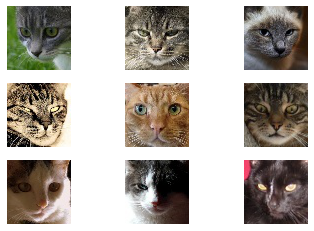

In [0]:
#Define variables
image_width = 64
image_height = 64
path = '/content/drive/My Drive/cs/cs344/cat_64x64.npy'
convertFolder = False

#Defining the Input shape 
image_shape = (64, 64, 3)    
latent_dim = 100

#load in cat data
X = load_data(convertFolder,path)

#display some images to test
for i in range(9):
	# define subplot
	pyplot.subplot(3, 3, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[randint(0, len(X))] / 255.0)
# show the figure
pyplot.show()
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

In [0]:
# define discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    # downsample to 32x32
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 4x4
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 2x2
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
# create the discriminator
d_model = define_discriminator()
d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)        

In [0]:
# define generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # upsample to 16x16
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # upsample to 32x32
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # upsample to 64x64
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)      

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         1728387   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1112577   
Total params: 2,840,964
Trainable params: 1,728,387
Non-trainable params: 1,112,577
_________________________________________________________________


In [0]:
#@title Add auxiliary helping functions
# get real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate fake samples 
# also add labels indicating their fakeness
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# plot generated images
def display_images(examples, n=3):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    pyplot.show() 
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    display_images(x_fake)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/123, d1=0.577, d2=0.334 g=3.491
>1, 2/123, d1=0.450, d2=0.272 g=2.772
>1, 3/123, d1=0.523, d2=0.568 g=2.768
>1, 4/123, d1=0.447, d2=0.339 g=2.910
>1, 5/123, d1=0.396, d2=0.238 g=2.595
>1, 6/123, d1=0.393, d2=0.328 g=2.611
>1, 7/123, d1=0.288, d2=0.317 g=3.056
>1, 8/123, d1=0.259, d2=0.124 g=2.998
>1, 9/123, d1=0.191, d2=0.231 g=2.889
>1, 10/123, d1=0.348, d2=0.208 g=2.726
>1, 11/123, d1=0.281, d2=0.323 g=3.048
>1, 12/123, d1=0.364, d2=0.272 g=2.758
>1, 13/123, d1=0.310, d2=0.305 g=2.843
>1, 14/123, d1=0.504, d2=0.409 g=3.035
>1, 15/123, d1=0.333, d2=0.213 g=3.010
>1, 16/123, d1=0.446, d2=0.325 g=2.557
>1, 17/123, d1=0.419, d2=0.462 g=2.790
>1, 18/123, d1=0.212, d2=0.263 g=3.443
>1, 19/123, d1=0.511, d2=0.343 g=2.987
>1, 20/123, d1=0.586, d2=0.529 g=3.089
>1, 21/123, d1=0.522, d2=0.286 g=3.148
>1, 22/123, d1=0.226, d2=0.127 g=3.288
>1, 23/123, d1=0.342, d2=0.279 g=3.230
>1, 24/123, d1=0.429, d2=0.176 g=3.425
>1, 25/123, d1=0.322, d2=0.115 g=3.259
>1, 26/123, d1=0.280, d2=0.126 g=2

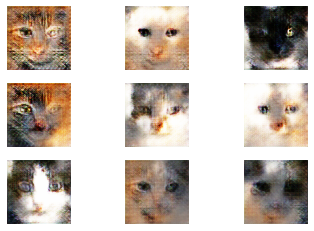

>11, 1/123, d1=0.566, d2=0.474 g=2.034
>11, 2/123, d1=0.221, d2=0.303 g=2.347
>11, 3/123, d1=0.593, d2=0.421 g=2.013
>11, 4/123, d1=0.329, d2=0.598 g=2.471
>11, 5/123, d1=0.567, d2=0.380 g=2.518
>11, 6/123, d1=0.527, d2=0.409 g=2.362
>11, 7/123, d1=0.399, d2=0.321 g=2.215
>11, 8/123, d1=0.510, d2=0.614 g=2.137
>11, 9/123, d1=0.536, d2=0.423 g=2.172
>11, 10/123, d1=0.523, d2=0.467 g=2.398
>11, 11/123, d1=0.565, d2=0.343 g=2.422
>11, 12/123, d1=0.502, d2=0.372 g=2.168
>11, 13/123, d1=0.505, d2=0.413 g=2.216
>11, 14/123, d1=0.488, d2=0.311 g=2.123
>11, 15/123, d1=0.451, d2=0.401 g=2.248
>11, 16/123, d1=0.346, d2=0.285 g=2.300
>11, 17/123, d1=0.368, d2=0.270 g=2.209
>11, 18/123, d1=0.342, d2=0.350 g=2.341
>11, 19/123, d1=0.359, d2=0.254 g=2.432
>11, 20/123, d1=0.270, d2=0.282 g=2.448
>11, 21/123, d1=0.300, d2=0.295 g=2.551
>11, 22/123, d1=0.283, d2=0.253 g=2.622
>11, 23/123, d1=0.327, d2=0.251 g=2.305
>11, 24/123, d1=0.339, d2=0.352 g=2.220
>11, 25/123, d1=0.293, d2=0.247 g=2.231
>11, 26/1

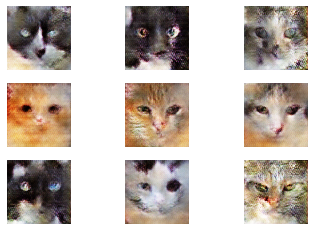

>21, 1/123, d1=0.446, d2=0.488 g=1.835
>21, 2/123, d1=0.681, d2=0.493 g=1.735
>21, 3/123, d1=0.457, d2=0.592 g=2.138
>21, 4/123, d1=0.602, d2=0.315 g=1.928
>21, 5/123, d1=0.355, d2=0.454 g=1.984
>21, 6/123, d1=0.355, d2=0.438 g=2.095
>21, 7/123, d1=0.409, d2=0.327 g=2.013
>21, 8/123, d1=0.443, d2=0.516 g=1.911
>21, 9/123, d1=0.450, d2=0.427 g=2.039
>21, 10/123, d1=0.485, d2=0.371 g=1.944
>21, 11/123, d1=0.383, d2=0.398 g=2.024
>21, 12/123, d1=0.555, d2=0.448 g=1.728
>21, 13/123, d1=0.430, d2=0.522 g=1.857
>21, 14/123, d1=0.382, d2=0.431 g=2.123
>21, 15/123, d1=0.549, d2=0.448 g=1.919
>21, 16/123, d1=0.428, d2=0.498 g=1.829
>21, 17/123, d1=0.424, d2=0.414 g=2.156
>21, 18/123, d1=0.596, d2=0.354 g=1.978
>21, 19/123, d1=0.444, d2=0.453 g=1.776
>21, 20/123, d1=0.436, d2=0.455 g=1.979
>21, 21/123, d1=0.488, d2=0.433 g=2.131
>21, 22/123, d1=0.371, d2=0.303 g=2.272
>21, 23/123, d1=0.445, d2=0.414 g=2.013
>21, 24/123, d1=0.503, d2=0.354 g=2.073
>21, 25/123, d1=0.472, d2=0.389 g=1.972
>21, 26/1

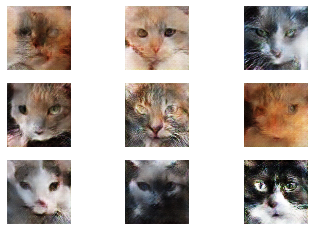

>31, 1/123, d1=0.661, d2=0.390 g=1.856
>31, 2/123, d1=0.449, d2=0.476 g=1.871
>31, 3/123, d1=0.529, d2=0.509 g=1.773
>31, 4/123, d1=0.502, d2=0.448 g=1.722
>31, 5/123, d1=0.522, d2=0.380 g=1.728
>31, 6/123, d1=0.637, d2=0.489 g=1.759
>31, 7/123, d1=0.478, d2=0.388 g=1.813
>31, 8/123, d1=0.459, d2=0.452 g=1.778
>31, 9/123, d1=0.478, d2=0.335 g=1.696
>31, 10/123, d1=0.488, d2=0.466 g=1.764
>31, 11/123, d1=0.433, d2=0.533 g=1.844
>31, 12/123, d1=0.471, d2=0.461 g=1.970
>31, 13/123, d1=0.492, d2=0.378 g=1.984
>31, 14/123, d1=0.493, d2=0.406 g=1.836
>31, 15/123, d1=0.611, d2=0.431 g=1.684
>31, 16/123, d1=0.412, d2=0.461 g=1.769
>31, 17/123, d1=0.534, d2=0.407 g=1.735
>31, 18/123, d1=0.440, d2=0.457 g=1.767
>31, 19/123, d1=0.450, d2=0.381 g=1.970
>31, 20/123, d1=0.406, d2=0.410 g=1.791
>31, 21/123, d1=0.430, d2=0.472 g=1.862
>31, 22/123, d1=0.420, d2=0.408 g=2.019
>31, 23/123, d1=0.560, d2=0.492 g=1.823
>31, 24/123, d1=0.569, d2=0.437 g=1.784
>31, 25/123, d1=0.512, d2=0.550 g=1.853
>31, 26/1

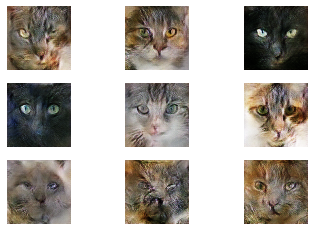

>41, 1/123, d1=0.530, d2=0.376 g=1.747
>41, 2/123, d1=0.457, d2=0.562 g=1.738
>41, 3/123, d1=0.525, d2=0.394 g=1.672
>41, 4/123, d1=0.555, d2=0.534 g=1.803
>41, 5/123, d1=0.465, d2=0.462 g=1.849
>41, 6/123, d1=0.560, d2=0.467 g=1.420
>41, 7/123, d1=0.401, d2=0.481 g=1.725
>41, 8/123, d1=0.602, d2=0.558 g=1.715
>41, 9/123, d1=0.477, d2=0.722 g=1.906
>41, 10/123, d1=0.397, d2=1.046 g=2.639
>41, 11/123, d1=1.046, d2=0.402 g=2.042
>41, 12/123, d1=0.543, d2=0.526 g=2.030
>41, 13/123, d1=0.517, d2=0.424 g=2.154
>41, 14/123, d1=0.344, d2=0.374 g=2.293
>41, 15/123, d1=0.456, d2=0.359 g=2.050
>41, 16/123, d1=0.528, d2=0.613 g=2.013
>41, 17/123, d1=0.637, d2=0.373 g=2.022
>41, 18/123, d1=0.600, d2=0.663 g=2.062
>41, 19/123, d1=0.663, d2=0.434 g=1.999
>41, 20/123, d1=0.588, d2=0.600 g=1.733
>41, 21/123, d1=0.458, d2=0.637 g=1.751
>41, 22/123, d1=0.579, d2=0.403 g=1.763
>41, 23/123, d1=0.520, d2=0.461 g=1.678
>41, 24/123, d1=0.708, d2=0.542 g=1.560
>41, 25/123, d1=0.502, d2=0.550 g=1.660
>41, 26/1

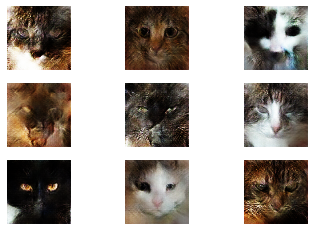

>51, 1/123, d1=0.549, d2=0.624 g=1.341
>51, 2/123, d1=0.437, d2=0.590 g=1.404
>51, 3/123, d1=0.548, d2=0.486 g=1.444
>51, 4/123, d1=0.665, d2=0.565 g=1.341
>51, 5/123, d1=0.454, d2=0.652 g=1.414
>51, 6/123, d1=0.456, d2=0.539 g=1.434
>51, 7/123, d1=0.432, d2=0.494 g=1.563
>51, 8/123, d1=0.605, d2=0.510 g=1.491
>51, 9/123, d1=0.567, d2=0.501 g=1.368
>51, 10/123, d1=0.468, d2=0.571 g=1.355
>51, 11/123, d1=0.498, d2=0.619 g=1.562
>51, 12/123, d1=0.551, d2=0.477 g=1.481
>51, 13/123, d1=0.618, d2=0.558 g=1.487
>51, 14/123, d1=0.575, d2=0.652 g=1.636
>51, 15/123, d1=0.522, d2=0.521 g=1.780
>51, 16/123, d1=0.634, d2=0.351 g=1.768
>51, 17/123, d1=0.674, d2=0.528 g=1.461
>51, 18/123, d1=0.517, d2=0.575 g=1.628
>51, 19/123, d1=0.539, d2=0.478 g=1.816
>51, 20/123, d1=0.665, d2=0.458 g=1.642
>51, 21/123, d1=0.648, d2=0.613 g=1.745
>51, 22/123, d1=0.469, d2=0.465 g=1.677
>51, 23/123, d1=0.532, d2=0.387 g=1.673
>51, 24/123, d1=0.603, d2=0.595 g=1.570
>51, 25/123, d1=0.492, d2=0.568 g=1.704
>51, 26/1

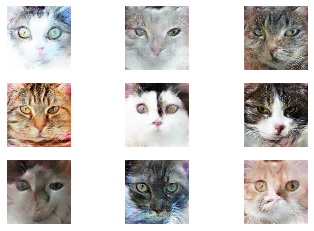

>61, 1/123, d1=0.575, d2=0.533 g=1.343
>61, 2/123, d1=0.522, d2=0.574 g=1.474
>61, 3/123, d1=0.569, d2=0.460 g=1.470
>61, 4/123, d1=0.722, d2=0.529 g=1.449
>61, 5/123, d1=0.527, d2=0.557 g=1.353
>61, 6/123, d1=0.673, d2=0.521 g=1.293
>61, 7/123, d1=0.544, d2=0.665 g=1.467
>61, 8/123, d1=0.604, d2=0.550 g=1.447
>61, 9/123, d1=0.571, d2=0.412 g=1.634
>61, 10/123, d1=0.612, d2=0.696 g=1.624
>61, 11/123, d1=0.690, d2=0.429 g=1.421
>61, 12/123, d1=0.525, d2=0.618 g=1.411
>61, 13/123, d1=0.623, d2=0.559 g=1.398
>61, 14/123, d1=0.612, d2=0.490 g=1.412
>61, 15/123, d1=0.434, d2=0.542 g=1.444
>61, 16/123, d1=0.598, d2=0.516 g=1.434
>61, 17/123, d1=0.537, d2=0.464 g=1.269
>61, 18/123, d1=0.478, d2=0.613 g=1.356
>61, 19/123, d1=0.509, d2=0.547 g=1.441
>61, 20/123, d1=0.566, d2=0.464 g=1.435
>61, 21/123, d1=0.493, d2=0.564 g=1.310
>61, 22/123, d1=0.488, d2=0.614 g=1.473
>61, 23/123, d1=0.460, d2=0.434 g=1.469
>61, 24/123, d1=0.533, d2=0.459 g=1.402
>61, 25/123, d1=0.455, d2=0.482 g=1.485
>61, 26/1

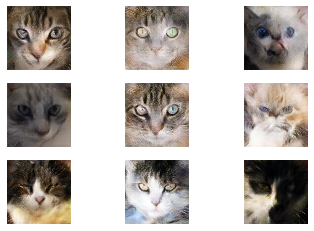

>71, 1/123, d1=0.532, d2=0.538 g=1.651
>71, 2/123, d1=0.577, d2=0.393 g=1.703
>71, 3/123, d1=0.572, d2=0.410 g=1.517
>71, 4/123, d1=0.547, d2=0.604 g=1.370
>71, 5/123, d1=0.502, d2=0.576 g=1.551
>71, 6/123, d1=0.457, d2=0.569 g=1.499
>71, 7/123, d1=0.645, d2=0.568 g=1.510
>71, 8/123, d1=0.517, d2=0.403 g=1.668
>71, 9/123, d1=0.649, d2=0.618 g=1.459
>71, 10/123, d1=0.601, d2=0.501 g=1.478
>71, 11/123, d1=0.362, d2=0.525 g=1.719
>71, 12/123, d1=0.430, d2=0.436 g=1.584
>71, 13/123, d1=0.533, d2=0.601 g=1.497
>71, 14/123, d1=0.582, d2=0.582 g=1.461
>71, 15/123, d1=0.518, d2=0.524 g=1.583
>71, 16/123, d1=0.584, d2=0.453 g=1.483
>71, 17/123, d1=0.469, d2=0.586 g=1.398
>71, 18/123, d1=0.555, d2=0.476 g=1.379
>71, 19/123, d1=0.527, d2=0.473 g=1.405
>71, 20/123, d1=0.565, d2=0.597 g=1.507
>71, 21/123, d1=0.610, d2=0.543 g=1.591
>71, 22/123, d1=0.654, d2=0.480 g=1.439
>71, 23/123, d1=0.664, d2=0.671 g=1.581
>71, 24/123, d1=0.558, d2=0.465 g=1.510
>71, 25/123, d1=0.629, d2=0.599 g=1.369
>71, 26/1

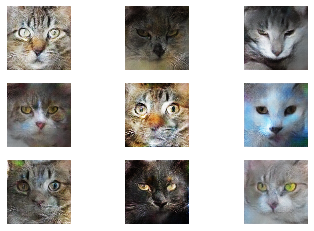

>81, 1/123, d1=0.637, d2=0.629 g=1.553
>81, 2/123, d1=0.489, d2=0.424 g=1.429
>81, 3/123, d1=0.672, d2=0.593 g=1.508
>81, 4/123, d1=0.553, d2=0.734 g=1.691
>81, 5/123, d1=0.665, d2=0.508 g=1.670
>81, 6/123, d1=0.670, d2=0.510 g=1.486
>81, 7/123, d1=0.482, d2=0.431 g=1.495
>81, 8/123, d1=0.515, d2=0.588 g=1.565
>81, 9/123, d1=0.475, d2=0.572 g=1.646
>81, 10/123, d1=0.597, d2=0.420 g=1.562
>81, 11/123, d1=0.599, d2=0.428 g=1.595
>81, 12/123, d1=0.461, d2=0.425 g=1.543
>81, 13/123, d1=0.565, d2=0.573 g=1.422
>81, 14/123, d1=0.400, d2=0.495 g=1.539
>81, 15/123, d1=0.557, d2=0.528 g=1.613
>81, 16/123, d1=0.636, d2=0.560 g=1.675
>81, 17/123, d1=0.579, d2=0.496 g=1.508
>81, 18/123, d1=0.535, d2=0.497 g=1.448
>81, 19/123, d1=0.480, d2=0.608 g=1.554
>81, 20/123, d1=0.482, d2=0.613 g=1.610
>81, 21/123, d1=0.533, d2=0.392 g=1.767
>81, 22/123, d1=0.582, d2=0.640 g=1.772
>81, 23/123, d1=0.617, d2=0.393 g=1.723
>81, 24/123, d1=0.501, d2=0.436 g=1.596
>81, 25/123, d1=0.468, d2=0.557 g=1.490
>81, 26/1

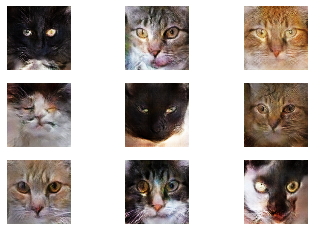

>91, 1/123, d1=0.463, d2=0.467 g=1.639
>91, 2/123, d1=0.363, d2=0.449 g=1.651
>91, 3/123, d1=0.401, d2=0.524 g=1.767
>91, 4/123, d1=0.411, d2=0.457 g=1.777
>91, 5/123, d1=0.338, d2=0.437 g=1.822
>91, 6/123, d1=0.422, d2=0.465 g=1.806
>91, 7/123, d1=0.586, d2=0.567 g=1.816
>91, 8/123, d1=0.674, d2=0.452 g=1.719
>91, 9/123, d1=0.664, d2=0.496 g=1.616
>91, 10/123, d1=0.535, d2=0.641 g=1.535
>91, 11/123, d1=0.472, d2=0.426 g=1.787
>91, 12/123, d1=0.545, d2=0.393 g=1.678
>91, 13/123, d1=0.517, d2=0.626 g=1.557
>91, 14/123, d1=0.477, d2=0.610 g=1.500
>91, 15/123, d1=0.569, d2=0.527 g=1.715
>91, 16/123, d1=0.555, d2=0.414 g=1.759
>91, 17/123, d1=0.526, d2=0.400 g=1.678
>91, 18/123, d1=0.511, d2=0.801 g=1.975
>91, 19/123, d1=0.674, d2=0.480 g=1.831
>91, 20/123, d1=0.662, d2=0.395 g=1.440
>91, 21/123, d1=0.528, d2=0.643 g=1.499
>91, 22/123, d1=0.456, d2=0.497 g=1.549
>91, 23/123, d1=0.454, d2=0.510 g=1.681
>91, 24/123, d1=0.492, d2=0.468 g=1.627
>91, 25/123, d1=0.398, d2=0.678 g=1.696
>91, 26/1

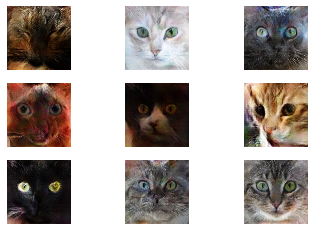

>101, 1/123, d1=0.614, d2=0.495 g=1.818
>101, 2/123, d1=0.423, d2=0.577 g=1.766
>101, 3/123, d1=0.541, d2=0.439 g=1.584
>101, 4/123, d1=0.428, d2=0.480 g=1.706
>101, 5/123, d1=0.452, d2=0.456 g=1.629
>101, 6/123, d1=0.457, d2=0.509 g=1.714
>101, 7/123, d1=0.439, d2=0.416 g=1.869
>101, 8/123, d1=0.581, d2=0.537 g=1.672
>101, 9/123, d1=0.348, d2=0.388 g=1.733
>101, 10/123, d1=0.528, d2=0.469 g=1.870
>101, 11/123, d1=0.432, d2=0.335 g=1.872
>101, 12/123, d1=0.370, d2=0.509 g=1.706
>101, 13/123, d1=0.363, d2=0.328 g=1.812
>101, 14/123, d1=0.511, d2=0.459 g=1.824
>101, 15/123, d1=0.444, d2=0.481 g=1.957
>101, 16/123, d1=0.596, d2=0.412 g=1.751
>101, 17/123, d1=0.464, d2=0.445 g=1.664
>101, 18/123, d1=0.424, d2=0.557 g=1.739
>101, 19/123, d1=0.468, d2=0.414 g=1.813
>101, 20/123, d1=0.492, d2=0.512 g=1.651
>101, 21/123, d1=0.439, d2=0.489 g=1.752
>101, 22/123, d1=0.498, d2=0.492 g=1.679
>101, 23/123, d1=0.539, d2=0.519 g=1.619
>101, 24/123, d1=0.490, d2=0.471 g=1.723
>101, 25/123, d1=0.587, d

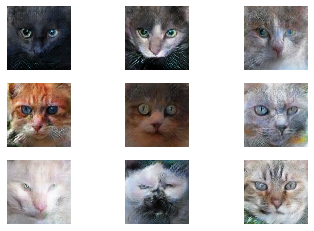

>111, 1/123, d1=0.451, d2=0.374 g=1.936
>111, 2/123, d1=0.595, d2=0.432 g=1.758
>111, 3/123, d1=0.550, d2=0.428 g=1.723
>111, 4/123, d1=0.388, d2=0.467 g=1.895
>111, 5/123, d1=0.441, d2=0.446 g=2.092
>111, 6/123, d1=0.599, d2=0.357 g=1.740
>111, 7/123, d1=0.502, d2=0.797 g=2.057
>111, 8/123, d1=0.538, d2=0.350 g=2.075
>111, 9/123, d1=0.482, d2=0.553 g=2.061
>111, 10/123, d1=0.499, d2=0.236 g=1.735
>111, 11/123, d1=0.431, d2=0.578 g=1.824
>111, 12/123, d1=0.460, d2=0.484 g=1.800
>111, 13/123, d1=0.414, d2=0.394 g=1.955
>111, 14/123, d1=0.364, d2=0.459 g=1.803
>111, 15/123, d1=0.362, d2=0.304 g=1.670
>111, 16/123, d1=0.507, d2=0.479 g=1.776
>111, 17/123, d1=0.296, d2=0.460 g=1.979
>111, 18/123, d1=0.387, d2=0.279 g=1.977
>111, 19/123, d1=0.417, d2=0.408 g=1.932
>111, 20/123, d1=0.307, d2=0.482 g=2.131
>111, 21/123, d1=0.577, d2=0.350 g=1.808
>111, 22/123, d1=0.462, d2=0.495 g=1.924
>111, 23/123, d1=0.396, d2=0.365 g=2.034
>111, 24/123, d1=0.402, d2=0.376 g=2.124
>111, 25/123, d1=0.477, d

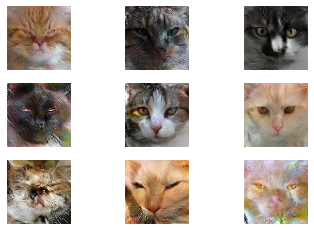

>121, 1/123, d1=0.476, d2=0.392 g=1.979
>121, 2/123, d1=0.297, d2=0.263 g=1.982
>121, 3/123, d1=0.406, d2=0.437 g=2.118
>121, 4/123, d1=0.592, d2=0.436 g=2.062
>121, 5/123, d1=0.491, d2=0.243 g=1.860
>121, 6/123, d1=0.294, d2=0.474 g=2.004
>121, 7/123, d1=0.309, d2=0.441 g=2.164
>121, 8/123, d1=0.334, d2=0.499 g=2.178
>121, 9/123, d1=0.484, d2=0.411 g=2.086
>121, 10/123, d1=0.479, d2=0.373 g=2.215
>121, 11/123, d1=0.526, d2=0.381 g=2.276
>121, 12/123, d1=0.380, d2=0.335 g=2.173
>121, 13/123, d1=0.557, d2=0.313 g=2.064
>121, 14/123, d1=0.375, d2=0.515 g=2.052
>121, 15/123, d1=0.411, d2=0.272 g=2.034
>121, 16/123, d1=0.390, d2=0.441 g=1.868
>121, 17/123, d1=0.303, d2=0.289 g=2.012
>121, 18/123, d1=0.300, d2=0.386 g=2.177
>121, 19/123, d1=0.409, d2=0.272 g=2.352
>121, 20/123, d1=0.491, d2=0.324 g=1.716
>121, 21/123, d1=0.293, d2=0.436 g=2.193
>121, 22/123, d1=0.411, d2=0.300 g=2.140
>121, 23/123, d1=0.304, d2=0.438 g=2.206
>121, 24/123, d1=0.332, d2=0.283 g=2.305
>121, 25/123, d1=0.513, d

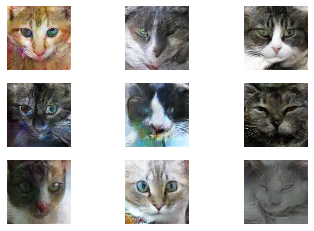

>131, 1/123, d1=0.336, d2=0.348 g=2.334
>131, 2/123, d1=0.449, d2=0.280 g=2.038
>131, 3/123, d1=0.222, d2=0.328 g=2.225
>131, 4/123, d1=0.349, d2=0.342 g=2.358
>131, 5/123, d1=0.385, d2=0.285 g=2.249
>131, 6/123, d1=0.304, d2=0.315 g=2.465
>131, 7/123, d1=0.380, d2=0.280 g=2.223
>131, 8/123, d1=0.428, d2=0.426 g=2.389
>131, 9/123, d1=0.330, d2=0.323 g=2.404
>131, 10/123, d1=0.429, d2=0.258 g=2.145
>131, 11/123, d1=0.363, d2=0.410 g=2.315
>131, 12/123, d1=0.416, d2=0.347 g=2.407
>131, 13/123, d1=0.291, d2=0.330 g=2.510
>131, 14/123, d1=0.464, d2=0.355 g=2.433
>131, 15/123, d1=0.507, d2=0.322 g=2.243
>131, 16/123, d1=0.332, d2=0.246 g=2.140
>131, 17/123, d1=0.279, d2=0.266 g=2.376
>131, 18/123, d1=0.302, d2=0.340 g=2.425
>131, 19/123, d1=0.450, d2=0.353 g=2.275
>131, 20/123, d1=0.334, d2=0.267 g=2.262
>131, 21/123, d1=0.386, d2=0.295 g=2.233
>131, 22/123, d1=0.318, d2=0.279 g=2.125
>131, 23/123, d1=0.159, d2=0.270 g=2.458
>131, 24/123, d1=0.321, d2=0.157 g=2.346
>131, 25/123, d1=0.408, d

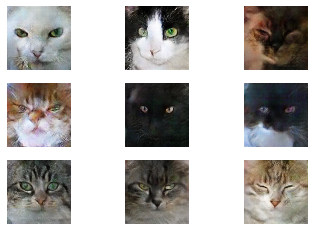

>141, 1/123, d1=0.233, d2=0.303 g=2.802
>141, 2/123, d1=0.440, d2=0.231 g=2.279
>141, 3/123, d1=0.241, d2=0.337 g=2.607
>141, 4/123, d1=0.222, d2=0.241 g=3.080
>141, 5/123, d1=0.636, d2=0.259 g=2.366
>141, 6/123, d1=0.364, d2=0.357 g=2.210
>141, 7/123, d1=0.318, d2=0.299 g=2.549
>141, 8/123, d1=0.429, d2=0.296 g=2.479
>141, 9/123, d1=0.224, d2=0.432 g=2.794
>141, 10/123, d1=0.401, d2=0.324 g=2.749
>141, 11/123, d1=0.463, d2=0.242 g=2.545
>141, 12/123, d1=0.416, d2=0.301 g=2.339
>141, 13/123, d1=0.320, d2=0.276 g=2.467
>141, 14/123, d1=0.127, d2=0.187 g=2.732
>141, 15/123, d1=0.371, d2=0.307 g=2.478
>141, 16/123, d1=0.394, d2=0.236 g=2.331
>141, 17/123, d1=0.306, d2=0.332 g=2.365
>141, 18/123, d1=0.307, d2=0.250 g=2.301
>141, 19/123, d1=0.327, d2=0.227 g=2.400
>141, 20/123, d1=0.310, d2=0.327 g=2.535
>141, 21/123, d1=0.414, d2=0.364 g=2.635
>141, 22/123, d1=0.375, d2=0.161 g=2.313
>141, 23/123, d1=0.386, d2=0.462 g=2.669
>141, 24/123, d1=0.308, d2=0.218 g=3.042
>141, 25/123, d1=0.263, d

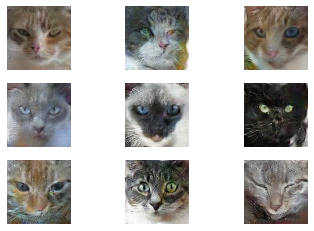

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=150, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create a goal of discriminater not detecting any fakes
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

# train model
train(g_model, d_model, gan_model, X, latent_dim)

In [ ]:
X, _ = generate_fake_samples(g_model, 100, 9)
display_images(X)


Demonstrate functionality from a saved model at 150 epochs

In [ ]:
# load model
display_model = load_model('generator_model_150.h5')
X, _ = generate_fake_samples(display_model, 100, 9)
display_images(X)

## Bibliography:

Brownlee, Jason. “How to Develop a GAN to Generate CIFAR10 Small Color Photographs.” Machine Learning Mastery, Machine Learning Mastery Pty, 24 July 2019, machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/.

Gupta, Alind. “Building a Generative Adversarial Network Using Keras.” GeeksforGeeks, 25 June 2019, www.geeksforgeeks.org/building-a-generative-adversarial-network-using-keras/.

Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).



In [0]:
## Bibliography:

Brownlee, Jason. “How to Develop a GAN to Generate CIFAR10 Small Color Photographs.” Machine Learning Mastery, Machine Learning Mastery Pty, 24 July 2019, machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/.

Gupta, Alind. “Building a Generative Adversarial Network Using Keras.” GeeksforGeeks, 25 June 2019, www.geeksforgeeks.org/building-a-generative-adversarial-network-using-keras/.

Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).



Demonstrate functionality from a saved model at 150 epochs

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


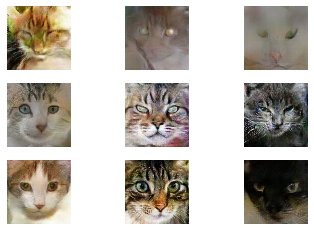

In [33]:
# load model
display_model = load_model('generator_model_150.h5')
X, _ = generate_fake_samples(display_model, 100, 9)
display_images(X)

## Bibliography:

Brownlee, Jason. “How to Develop a GAN to Generate CIFAR10 Small Color Photographs.” Machine Learning Mastery, Machine Learning Mastery Pty, 24 July 2019, machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/.

Gupta, Alind. “Building a Generative Adversarial Network Using Keras.” GeeksforGeeks, 25 June 2019, www.geeksforgeeks.org/building-a-generative-adversarial-network-using-keras/.

Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

